In [1]:
import numpy as np
import os
import PIL as Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import tensorflow.keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow

In [90]:
import splitfolders
from tensorflow.keras import layers
from tensorflow import keras

In [156]:
input_folder = "/Users/viralmehta/Downloads/CellData/chest_xray"
output = "/Users/viralmehta/Downloads/CellData/chest_xraynew"

splitfolders.ratio(input_folder, output, ratio=(.75, .10, .15))

In [157]:
train_folder= '/Users/viralmehta/Downloads/CellData/chest_xraynew/train'
#train_folder= '/Users/Razor56M/Downloads/output_american/train'

test_folder= '/Users/viralmehta/Downloads/CellData/chest_xraynew/test'
#test_folder= '/Users/Razor56M/Downloads/output_american/test'

val_folder= '/Users/viralmehta/Downloads/CellData/chest_xraynew/val'

In [158]:
batch= 32
#133: 10 epochs: 0.3842
image_input= (224, 224)

In [159]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)
test_datagen= ImageDataGenerator(rescale=1./255)


In [ ]:
training_set= train_datagen.flow_from_directory(train_folder, 
                                                target_size=image_input, 
                                                batch_size=batch, 
                                                class_mode= 'binary')

test_set= test_datagen.flow_from_directory(test_folder, 
                                           target_size=image_input, 
                                           batch_size=1, 
                                           class_mode= 'binary',
                                           shuffle = False)

val= test_datagen.flow_from_directory(val_folder, 
                                           target_size=image_input, 
                                           batch_size=batch, 
                                           class_mode= 'binary')

In [165]:

base_model = tensorflow.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(224, 224, 1),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(224, 224, 1))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [166]:
classifier = get_pretrained()
classifier.compile(optimizer = keras.optimizers.Adam(learning_rate=5e-5), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [167]:
history = classifier.fit(training_set,
          batch_size = batch, epochs = 20,
          validation_data=val,
          steps_per_epoch=130,
          validation_steps=32)

Epoch 1/20
130/130 [==============================] - 177s 1s/step - loss: 0.3975 - binary_accuracy: 0.8286 - val_loss: 0.2211 - val_binary_accuracy: 0.9258 - lr: 5.0000e-05
Epoch 2/20
130/130 [==============================] - 180s 1s/step - loss: 0.2080 - binary_accuracy: 0.9200 - val_loss: 0.1544 - val_binary_accuracy: 0.9443 - lr: 5.0000e-05
Epoch 3/20
130/130 [==============================] - 178s 1s/step - loss: 0.1729 - binary_accuracy: 0.9376 - val_loss: 0.1509 - val_binary_accuracy: 0.9473 - lr: 5.0000e-05
Epoch 4/20
130/130 [==============================] - 187s 1s/step - loss: 0.1468 - binary_accuracy: 0.9456 - val_loss: 0.1319 - val_binary_accuracy: 0.9551 - lr: 5.0000e-05
Epoch 5/20
130/130 [==============================] - 191s 1s/step - loss: 0.1408 - binary_accuracy: 0.9488 - val_loss: 0.1242 - val_binary_accuracy: 0.9580 - lr: 5.0000e-05
Epoch 6/20
130/130 [==============================] - 183s 1s/step - loss: 0.1243 - binary_accuracy: 0.9570 - val_loss: 0.1353 - v

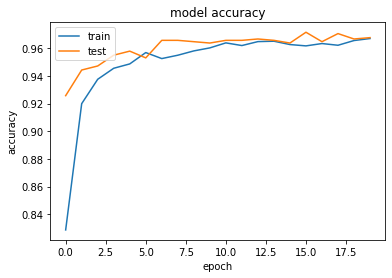

In [168]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

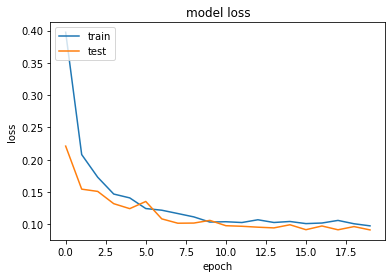

In [169]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [170]:
test_accu = classifier.evaluate(test_set)
print('The testing accuracy is :',test_accu[1]*100, '%')

624/624 [==============================] - 25s 37ms/step - loss: 0.2846 - binary_accuracy: 0.8846
The testing accuracy is : 88.4615421295166 %


In [181]:
print('The testing accuracy loss :',test_accu[0])

The testing accuracy loss : 0.2846226096153259


In [172]:
from sklearn.metrics import accuracy_score
test_set.reset()
Y_test = test_set.classes
predictions = classifier.predict(test_set)
pred_labels= np.where(predictions>0.5, 1, 0)

print("Test Accuracy: ", accuracy_score(Y_test, pred_labels.flatten()))

Test Accuracy:  0.8846153846153846


In [173]:
class_names = test_set.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_labels)

In [188]:
pred_labels.flatten()

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [174]:
class_names

dict_keys(['NORMAL', 'PNEUMONIA'])

In [175]:
cnf_matrix

array([[170,  64],
       [  8, 382]])

<AxesSubplot:>

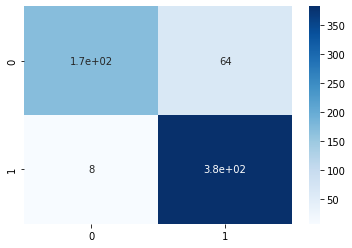

In [202]:
import seaborn
seaborn.heatmap(cnf_matrix, annot=True, cmap='Blues')

In [217]:
print('True Positive Rate:', round(cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[1][0]), 2)*100, "%.")
print('True Negative Rate:', round(cnf_matrix[0][0]/(cnf_matrix[0][0]+cnf_matrix[0][1]), 2)*100, "%.")
print('False Positive Rate:', round(cnf_matrix[1][0]/(cnf_matrix[1][1]+cnf_matrix[1][0]), 2)*100, "%.")
print('False Negative Rate:', round(cnf_matrix[0][1]/(cnf_matrix[0][0]+cnf_matrix[0][1]), 2)*100, "%.")

True Positive Rate: 98.0 %.
True Negative Rate: 73.0 %.
False Positive Rate: 2.0 %.
False Negative Rate: 27.0 %.


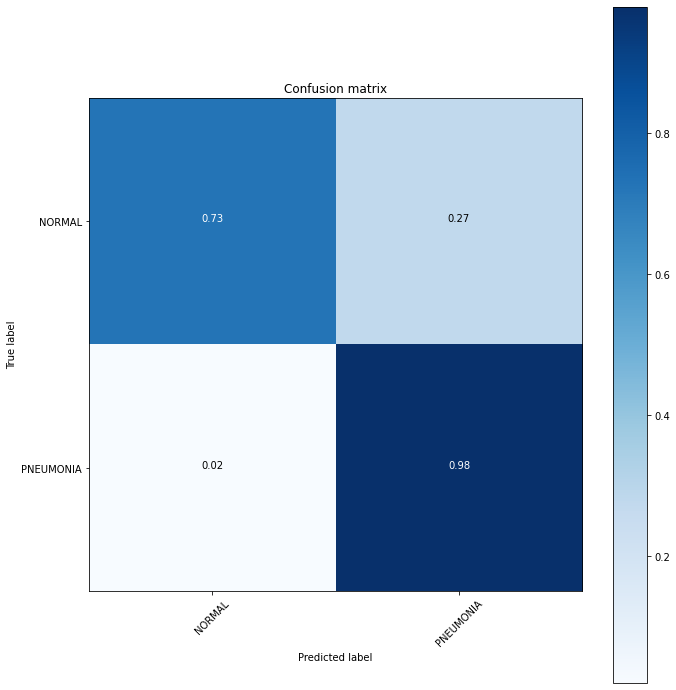

In [178]:
plot_confusion_matrix(cnf_matrix, class_names)  
plt.show()